# Packet-Scheduling with Reinforcement Learning

**Objective**  
Build and compare:
1. A custom Gym env for three-class packet scheduling (video/voice/best-effort).  
2. Three fixed scheduling policies (FIFO, EDF, Sequential Priority).  
3. A tabular Q-learning agent that meets hard-deadline constraints on P1/P2 while minimizing P3 delay for scenario 1.
4. ...


**Notebook roadmap**  
1. [Problem formulation (MDP)](#formulation)  
2. [Environment implementation](#env)  
3. [Baseline policies](#baselines)  
4. [Reinforcement-learning agent](#rl-agent)  
5. [Results & comparison](#results)  
6. [Conclusions & next steps](#conclusion)  

## 1. MDP Formulation

- **State**  
  - \(q_i\): queue lengths for Video (P1), Voice (P2), Best-Effort (P3).  
  - Slack times \(\Delta_1, \Delta_2\) for P1/P2 head-of-line packets.  
  - Current queue pointer \(c\).  

- **Actions**  
  - Low-spec router: serve current queue, switch queue
  - High-spec router: switch-and-serve  

- **Reward**  
  - ...

- **Performance metrics**  
  - Deadline violations (P1,P2)  
  - Mean delay for P3  

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Env, spaces
from IPython.display import clear_output
import time
from collections import defaultdict

## 2. PacketSchedulerEnv

We implement a Gym Env with:
- Poisson arrivals (λ₁=0.3, λ₂=0.25, λ₃=0.4)
- Three FIFO queues with per-queue QoS limits [6,4,None]
- Two scenarios:  
  1. Low-spec router (three actions available -- switch queue, serve queue, and do nothing -- both with cost of one timeslot)  
  2. High-spec router (two actiona available -- switch queue and serve, serve current queue, and do nothing -- both of which have a cost of one timeslot) *still need to implement*

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Env, spaces
from IPython.display import clear_output

class PacketSchedulerEnv(Env):
    """
    OpenAI Gymnasium environment simulating packet scheduling across three queues:
    """

    def __init__(self, scenario=1):
        """
        Constructor
        takes the scenario 1 or 2 as arguments
        """
        super().__init__()
        self.num_queues = 3
        self.max_queue_size = 50
        self.scenario = scenario
        self.current_queue = 0
        self.time = 0
        # keeping it for checking empty queue serving
        self.empty_serving = 0 

        self.qos_limits = [6, 4, None]
        self.arrival_probs = [0.3, 0.25, 0.4]

        self.observation_space = spaces.Box(
            low=0, high=self.max_queue_size, shape=(self.num_queues,), dtype=np.int32
        )
        self.action_space = spaces.Discrete(self.num_queues if scenario == 1 else 2)

        self.history = []
        self.reset()
        # saving rewards of episodes
        self.episode_rewards = [] 

    def reset(self, seed=None, options=None):
        """Reset the environment to the initial state."""
        super().reset(seed=seed)
        # handling uniform seed
        if seed is not None:
            np.random.seed(seed)
            
        self.initialize_queues()
        self.reset_state()
        return self.get_observations(), {}

    def initialize_queues(self):
        """Initialize empty queues for each traffic class."""
        self.queues = [[] for _ in range(self.num_queues)]

    def reset_state(self):
        """Reset simulation states"""
        self.time = 0
        self.current_queue = 0
        self.history = []
        self.served_delays = [[] for _ in range(self.num_queues)]
        self.violations = [0, 0]
        self.total_episode_reward = 0
        self.empty_serving = 0 # resetting empty serving count

    def get_observations(self):
        """Return the current queue length observations"""
        return np.array([len(q) for q in self.queues])

    def generate_packets(self):
        """Randomly generate packets based on per-queue arrival rates."""
        for queue_id, rate in enumerate(self.arrival_probs):
            if self.should_generate_packet(rate):
                self.try_enqueue_packet(queue_id, self.time)

    def should_generate_packet(self, rate):
        """True if packets should be generated ."""
        return np.random.rand() < rate

    def try_enqueue_packet(self, queue_id, arrival_time):
        """Add packet to queue if not full."""
        if len(self.queues[queue_id]) < self.max_queue_size:
            self.queues[queue_id].append(arrival_time)

    def serve_queue(self, queue_idx):
        """Serves to Queue"""
        if not self.queue_has_packets(queue_idx):
            return self.empty_queue_penalty()

        arrival_time = self.queues[queue_idx].pop(0)
        delay = self.compute_packet_delay(arrival_time)

        self.served_delays[queue_idx].append(delay)

       # check if vid and voice violates qos 
        if queue_idx < 2 and delay > self.qos_limits[queue_idx]:
            self.violations[queue_idx] += 1

        return self.compute_reward(queue_idx, delay)

    def queue_has_packets(self, queue_idx):
        """Checks if thee's at least one packet in queue"""
        return len(self.queues[queue_idx]) > 0

    def empty_queue_penalty(self):
        """empty queue serve penalty"""
        self.empty_serving += 1
        return -1

    def compute_packet_delay(self, arrival_time):
        """Compute the delay for packet"""
        return self.time - arrival_time

    def compute_reward(self, queue_idx, delay):
        """Compute reward based on delay and QoS constraints."""
        qos_limit = self.qos_limits[queue_idx]
        if qos_limit is not None:
            return 1 if delay <= qos_limit else -1
        else:
            return max(0, 1 - 0.05 * delay)

    def process_action(self, action):
        """Choses which queue to serve"""
        if self.scenario == 1:
            return action, 0
        elif self.scenario == 2:
            if action == 1:
                self.switch_queue()
                return None, -0.2
            else:
                return self.current_queue, 0

    def switch_queue(self):
        """sitching queue"""
        self.current_queue = (self.current_queue + 1) % self.num_queues
        self.time += 1

    def serve_and_advance(self, queue_idx):
        """serve from queue and increment time +1"""
        reward = self.serve_queue(queue_idx)
        self.time += 1
        return reward

    def step(self, action):
        """simulates single unit of time in router operation"""
        self.generate_packets()
        selected_queue, reward = self.process_action(action)
        
        if selected_queue is not None:
            reward = self.serve_and_advance(selected_queue)
        # update reward
        self.total_episode_reward += reward
        terminated = False
        truncated = False
        return self.get_observations(), reward, terminated, truncated, {}

    def draw_network_queue(self):
        """visual output to see traffic"""
        queue_lengths = [len(q) for q in self.queues]
        self.history.append(queue_lengths)

        clear_output(wait=True)
        plt.figure(figsize=(5, 4))
        plt.bar(["Video", "Voice", "Best-Effort"], queue_lengths, color=["blue", "orange", "green"])
        plt.ylim(0, self.max_queue_size)
        plt.title(f"Time Step: {self.time}")
        plt.ylabel("Packets in Queue")
        plt.grid(True)
        plt.show()

    def get_statistics(self):
        """To check output statistics."""
        queue_lengths = [len(q) for q in self.queues]
        total_packets = [len(q) for q in self.served_delays]
        mean_delays = [np.mean(q) if q else None for q in self.served_delays]
        violation_rates = [
            self.violations[i] / max(1, len(self.served_delays[i]))
            for i in range(2)
        ]

        return {
            'queue_lengths': queue_lengths,
            'total_packets': total_packets,
            'mean_delays': mean_delays,
            'qos_violations': self.violations,
            'violation_rates': violation_rates,
            'empty_queue_penalty_count': self.empty_serving 
        }
        
    def generate_queue_bin(self, bins=(5, 5, 5)):
        """Convert queue lengths to bins using floor division."""
        binned_state = []

        for i in range(self.num_queues):
            queue_length = len(self.queues[i]) 
            total_bins = bins[i]
            # Size of each bin
            bin_size = self.max_queue_size // total_binn

            # handling zero div error if occurs
            if bin_size == 0:
                bin_size = 1

            # set queue to bin
            bin_index = queue_length // bin_size     

            # Cap the bin index to max allowed
            bin_index = min(bin_index, total_bins - 1)

            binned_state.append(bin_index)

        return tuple(binned_state)



### 2.1. Quick Environment Sanity Check

Instantiate the env with random policy for packet scheduling and print its initial statistics.

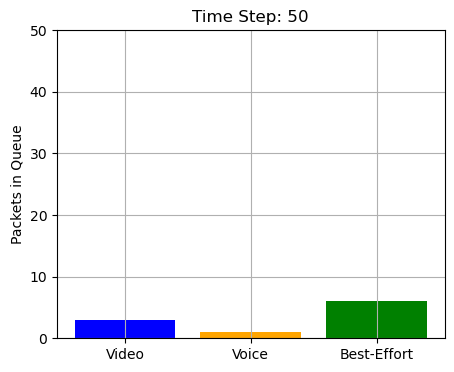

In [3]:
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

for _ in range(50):
    action = env.action_space.sample()  # Random policy
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.2)


In [4]:
env.get_statistics()

{'queue_lengths': [3, 1, 6],
 'total_packets': [14, 16, 12],
 'mean_delays': [2.642857142857143, 8.5625, 6.583333333333333],
 'qos_violations': [1, 12],
 'violation_rates': [0.07142857142857142, 0.75],
 'empty_queue_penalty_count': 8}

## 3. Baseline Policies

We’ll now compare three fixed schedulers under the same traffic:
1. **FIFO** – serve the oldest arrival  
2. **EDF** – serve the packet with minimum (deadline – current_wait). i.e. closest to QoS breach  
3. **Sequential Priority** – always serve the highest-priority non-empty queue

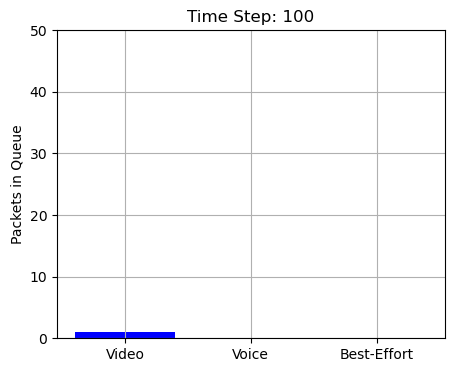

FIFO policy results: {'queue_lengths': [1, 0, 0], 'total_packets': [31, 25, 39], 'mean_delays': [2.935483870967742, 3.2, 3.6153846153846154], 'qos_violations': [0, 4], 'violation_rates': [0.0, 0.16], 'empty_queue_penalty_count': 5}


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Always serve the packet that arrived earliest
# ─────────────────────────────────────────────────────────────────────────────

# 1. Instantiate & reset
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

# 2. Run for T steps under FIFO
T = 100
for t in range(T):
    # Look at the head‐of‐line arrival time in each queue (or ∞ if empty)
    arrival_times = [
        q[0] if len(q) > 0 else float('inf')
        for q in env.queues
    ]
    # Pick the queue whose first packet arrived earliest
    action = int(np.argmin(arrival_times))
    
    # Step the environment
    obs, reward, done, truncated, info = env.step(action)
    
    # (Optional) visualize queue lengths live
    env.draw_network_queue()
    time.sleep(0.1)

# 3. Gather & print post‐run statistics
stats = env.get_statistics()
print("FIFO policy results:", stats)

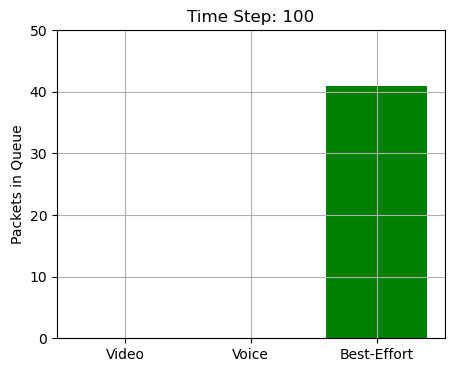

Slack‐aware policy results: {'queue_lengths': [0, 0, 41], 'total_packets': [31, 32, 0], 'mean_delays': [0.8387096774193549, 1.0, None], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 37}


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# always serve the packet whose (qos_limit – accumulated_delay) is smallest
# ─────────────────────────────────────────────────────────────────────────────

# 1) instantiate & reset
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

# 2) pull out the per‐queue QoS limits (mean‐delay requirements)
mean_reqs = env.qos_limits    # e.g. [6, 4, None]

# 3) run for T steps
T = 100
for t in range(T):
    slacks = []
    for i, q in enumerate(env.queues):
        # if queue is non‐empty and has a finite QoS limit
        if q and (mean_reqs[i] is not None):
            arrival_time = q[0]                   # packets stored as simple arrival_time
            acc_delay    = env.time - arrival_time  # or t – arrival_time, both track sim time
            slack        = mean_reqs[i] - acc_delay
        else:
            # empty queue or no deadline ⇒ never highest priority
            slack = float('inf')
        slacks.append(slack)

    # choose the queue with minimum slack
    action = int(np.argmin(slacks))

    # step the env 
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)

# 4) final statistics
stats = env.get_statistics()
print("Slack‐aware policy results:", stats)

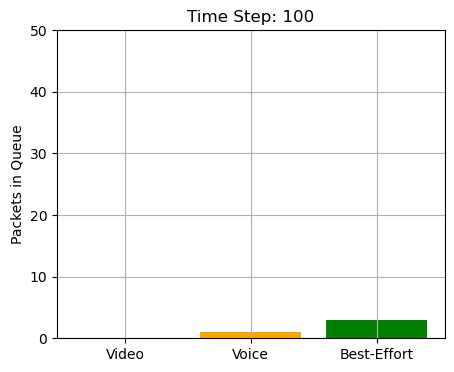

Priority‐policy results: {'queue_lengths': [0, 1, 3], 'total_packets': [32, 18, 41], 'mean_delays': [0.84375, 1.1111111111111112, 3.7804878048780486], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 9}


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# always serve the highest‐priority non‐empty queue
# ─────────────────────────────────────────────────────────────────────────────

# 1) instantiate & reset
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

# 2) run for T steps
T = 100
for t in range(T):
    # pick the highest‐priority non‐empty queue
    action = None
    for q_idx in range(env.num_queues):
        if env.queues[q_idx]:
            action = q_idx
            break
    # if all queues empty, default to queue 0 (no service will happen)
    if action is None:
        action = 0

    # step & visualize
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)

# 3) report statistics
stats = env.get_statistics()
print("Priority‐policy results:", stats)

## 5. Tabular Q-Learning Agent

We’ll train a tabular Q-learning agent using scenario 1:
- **State**: discretized queue lengths  
- **Action space**: 3 choices (switch queue, serve queue, do nothing)
- **Hyperparameters**:  
  - α=0.1, γ=0.99  
  - ε-greedy exploration (ε₀=1.0 → εₘᵢₙ=0.01)  
  - Episodes=500, max_steps=100  

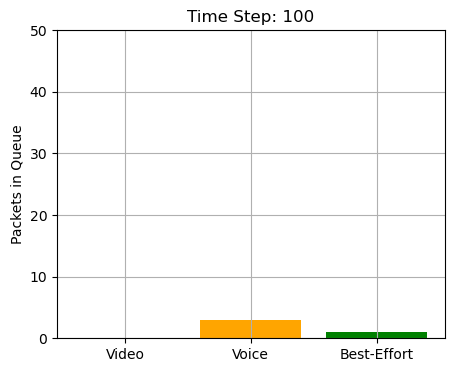

Trained Q-Learning policy results: {'queue_lengths': [0, 3, 1], 'total_packets': [31, 20, 40], 'mean_delays': [1.1935483870967742, 1.9, 2.75], 'qos_violations': [0, 2], 'violation_rates': [0.0, 0.1], 'empty_queue_penalty_count': 9}


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Tabular Q-Learning for PacketSchedulerEnv (scenario 1)
# ─────────────────────────────────────────────────────────────────────────────


# 1) Create the environment
env = PacketSchedulerEnv(scenario=1)

# 2) Q-table: maps state (tuple) → array of action-values
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# 3) Hyperparameters
alpha         = 0.1    # learning rate
gamma         = 0.99   # discount factor
epsilon       = 1.0    # initial exploration rate
epsilon_min   = 0.01   # minimum ε
epsilon_decay = 0.995  # multiplicative decay per episode
num_episodes  = 500
max_steps     = 100    # max steps per episode

# 4) Training loop
for ep in range(1, num_episodes+1):
    obs, _ = env.reset()
    state = tuple(obs)            # cast observation to immutable
    total_reward = 0.0

    for t in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q[state]))

        # take action
        obs2, reward, done, truncated, info = env.step(action)
        next_state = tuple(obs2)
        total_reward += reward

        # Q-learning update
        best_next = np.max(Q[next_state])
        td_target = reward + gamma * best_next
        Q[state][action] += alpha * (td_target - Q[state][action])

        state = next_state
        if done or truncated:
            break

    # decay ε
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if ep % 50 == 0:
        print(f"Episode {ep}/{num_episodes}  total_reward={total_reward:.1f}  ε={epsilon:.3f}")

# 5) Evaluate the learned policy
obs, _ = env.reset()
state = tuple(obs)
for t in range(100):
    action = int(np.argmax(Q[state]))
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)
    state = tuple(obs)
    if done or truncated:
        break

print("Trained Q-Learning policy results:", env.get_statistics())

In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# Tabular Q-Learning for PacketSchedulerEnv (scenario 2)
# ─────────────────────────────────────────────────────────────────────────────
# 1) Create the environment
env = PacketSchedulerEnv(scenario=2)

# 2) Q-table: maps state (tuple) → array of action-values
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
# testing with linear decay
# epsilon = max(epsilon_min, epsilon - 0.001)
epsilon_min = 0.09

epsilon_decay = 0.1
num_episodes = 1000
max_steps = 100

# logging info
episode_rewards = []
violation_rates_video = []
violation_rates_voice = []
empty_serve_counts = []

# Training loop
for ep in range(1, num_episodes + 1):
    obs, _ = env.reset(seed=ep)  # Optional reproducibility
    current_queue = env.current_queue
    state = (env.current_queue,) + tuple(len(q) for q in env.queues)
    total_reward = 0

    for t in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q[state]))

        # Take action
        obs2, reward, done, truncated, _ = env.step(action)

        # Prepare next state
        next_state = (env.current_queue,) + tuple(len(q) for q in env.queues)

        # Q-learning update
        best_next = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

        # Move to next state
        state = next_state
        total_reward += reward

        if done or truncated:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    ### logging values
    stats = env.get_statistics()
    episode_rewards.append(total_reward)
    violation_rates_video.append(stats['violation_rates'][0])
    violation_rates_voice.append(stats['violation_rates'][1])
    empty_serve_counts.append(stats['empty_queue_penalty_count'])
    # Print every 50 episodes
    if ep % 20 == 0:
        print(f"Episode {ep}/{num_episodes} | Reward: {total_reward:.2f} | "
                f"Video Violation: {stats['violation_rates'][0]:.2f} | "
                f"Voice Violation: {stats['violation_rates'][1]:.2f} | "
                f"Epsilon: {epsilon:.3f}")


Episode 20/1000 | Reward: 0.40 | Video Violation: 0.54 | Voice Violation: 0.71 | Epsilon: 0.090
Episode 40/1000 | Reward: 3.55 | Video Violation: 0.64 | Voice Violation: 0.94 | Epsilon: 0.090
Episode 60/1000 | Reward: 17.90 | Video Violation: 0.53 | Voice Violation: 1.00 | Epsilon: 0.090
Episode 80/1000 | Reward: 5.35 | Video Violation: 0.56 | Voice Violation: 1.00 | Epsilon: 0.090
Episode 100/1000 | Reward: 13.65 | Video Violation: 0.33 | Voice Violation: 1.00 | Epsilon: 0.090
Episode 120/1000 | Reward: 17.05 | Video Violation: 0.67 | Voice Violation: 1.00 | Epsilon: 0.090
Episode 140/1000 | Reward: 19.10 | Video Violation: 0.45 | Voice Violation: 0.82 | Epsilon: 0.090
Episode 160/1000 | Reward: 9.65 | Video Violation: 0.62 | Voice Violation: 1.00 | Epsilon: 0.090
Episode 180/1000 | Reward: -13.85 | Video Violation: 0.44 | Voice Violation: 1.00 | Epsilon: 0.090
Episode 200/1000 | Reward: 22.00 | Video Violation: 0.14 | Voice Violation: 0.88 | Epsilon: 0.090
Episode 220/1000 | Reward: 

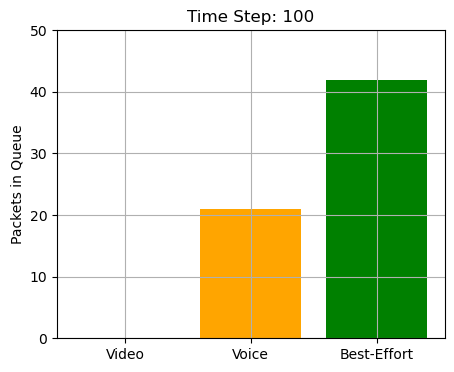

In [10]:
# 5) Evaluate the learned policy
obs, _ = env.reset()
state = tuple(obs)
for t in range(100):
    action = int(np.argmax(Q[state]))
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)
    state = tuple(obs)
    if done or truncated:
        break

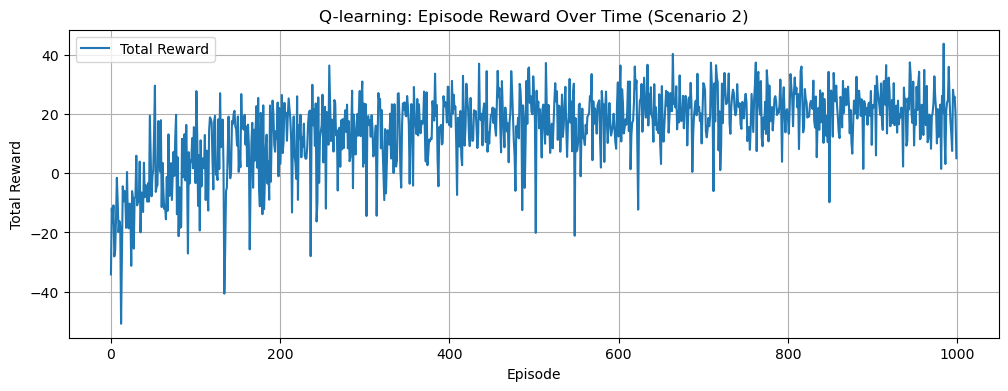

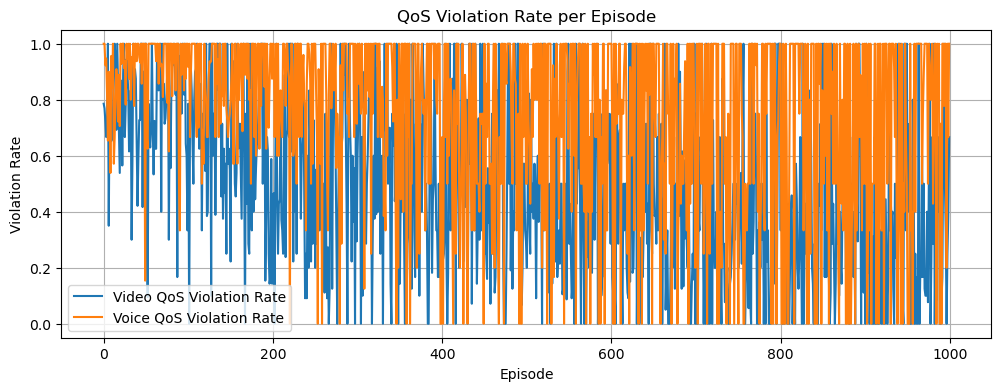

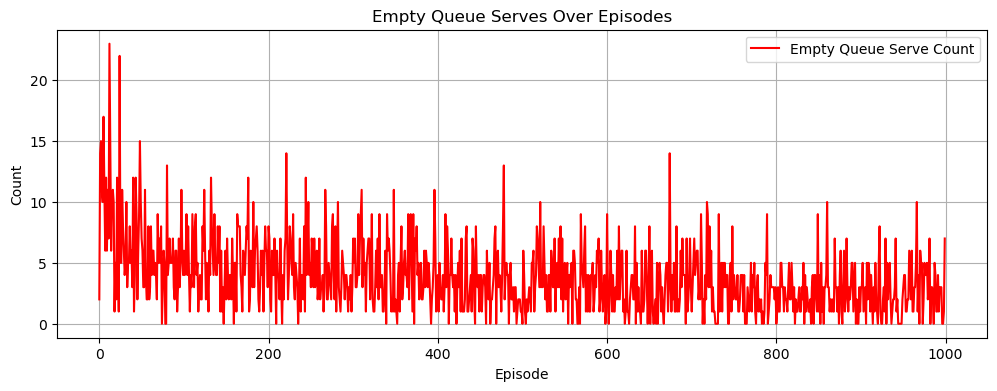

In [11]:
# Plot total rewards per episode
plt.figure(figsize=(12, 4))
plt.plot(episode_rewards, label='Total Reward')
plt.title('Q-learning: Episode Reward Over Time (Scenario 2)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.show()

# Plot violation rates
plt.figure(figsize=(12, 4))
plt.plot(violation_rates_video, label='Video QoS Violation Rate')
plt.plot(violation_rates_voice, label='Voice QoS Violation Rate')
plt.title('QoS Violation Rate per Episode')
plt.xlabel('Episode')
plt.ylabel('Violation Rate')
plt.grid(True)
plt.legend()
plt.show()

# Plot empty serve counts
plt.figure(figsize=(12, 4))
plt.plot(empty_serve_counts, label='Empty Queue Serve Count', color='red')
plt.title('Empty Queue Serves Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()
